In [ ]:
"""
see how well the density and reconstruction loss are related for different token counts
"""

In [1]:
import json
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
sys.path.append(os.path.abspath(".."))   # one level up from notebook/
from data.utils.dataloaders import clean_ReconstructionDataset_Heuristic

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read reconstruction loss json file 
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_APG_on.json', 'r') as f:
    reconst_losses = json.load(f)

In [59]:
# load densities
main_folder = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/clean/list_version/val_density_div_list_reconst_"

density_dict = {}
k_values = [1,2,4,8,16,32,64,128,256]
for k in k_values:
    with open((main_folder + f"{k}/token_count/0_0000_0200.json"), 'r') as f:
        current_densities = json.load(f)
    density_dict[k]=current_densities

print(density_dict.keys(), len(density_dict[1]), len(density_dict[2]), len(density_dict[4]), len(density_dict[8]), len(density_dict[16]), len(density_dict[32]), len(density_dict[64]), len(density_dict[128]), len(density_dict[256]))

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256]) 4000 4000 4000 4000 4000 4000 4000 4000 4000


In [64]:
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]

corrs = []

for j in range(50):
    corr = []
    for k in k_values:
        density = density_dict[k]

        max_density_index = len(density)  # upper bound (exclusive)
        # Filter reconstruction entries to those that have a density available
        filtered_reconst_losses = [
            rec for rec in reconst_losses
            if 'image_id' in rec and int(rec['image_id']) < max_density_index
        ]

        processed_density_dict = {}
        for idx, (key, value) in enumerate(density_dict.items()):
            processed_density_dict[key] = [sum(v[0][j:]) + v[1] for v in value]
        #print(processed_density_dict[k][0:10])
        ds = clean_ReconstructionDataset_Heuristic(
            reconstruction_data=filtered_reconst_losses,  # or your processed list of dicts
            local_density_information=processed_density_dict, # [l[0] for l in density]
            error_key=["LPIPS"],
        )
        
        densities    = []
        losses_lpips = []
        for data_point in ds:
            if data_point['k_value'] == k:
                densities.append(data_point['local_density'])
                losses_lpips.append(data_point['LPIPS'])
        corr1 = np.corrcoef(densities, losses_lpips)[0, 1]
        corr.append(corr1)
    corrs.append(corr)

In [65]:
for idx, k in enumerate(k_values):
    best_j = min(range(50), key=lambda j: corrs[j][idx])
    best_corr = corrs[best_j][idx]
    print(f"Best j for k={k} is {best_j} with correlation {best_corr:.4f}")

Best j for k=1 is 0 with correlation -0.1255
Best j for k=2 is 0 with correlation -0.2355
Best j for k=4 is 0 with correlation -0.4936
Best j for k=8 is 0 with correlation -0.5587
Best j for k=16 is 0 with correlation -0.6291
Best j for k=32 is 0 with correlation -0.6827
Best j for k=64 is 0 with correlation -0.7208
Best j for k=128 is 0 with correlation -0.7599
Best j for k=256 is 0 with correlation -0.7756


NameError: name 'density_list' is not defined

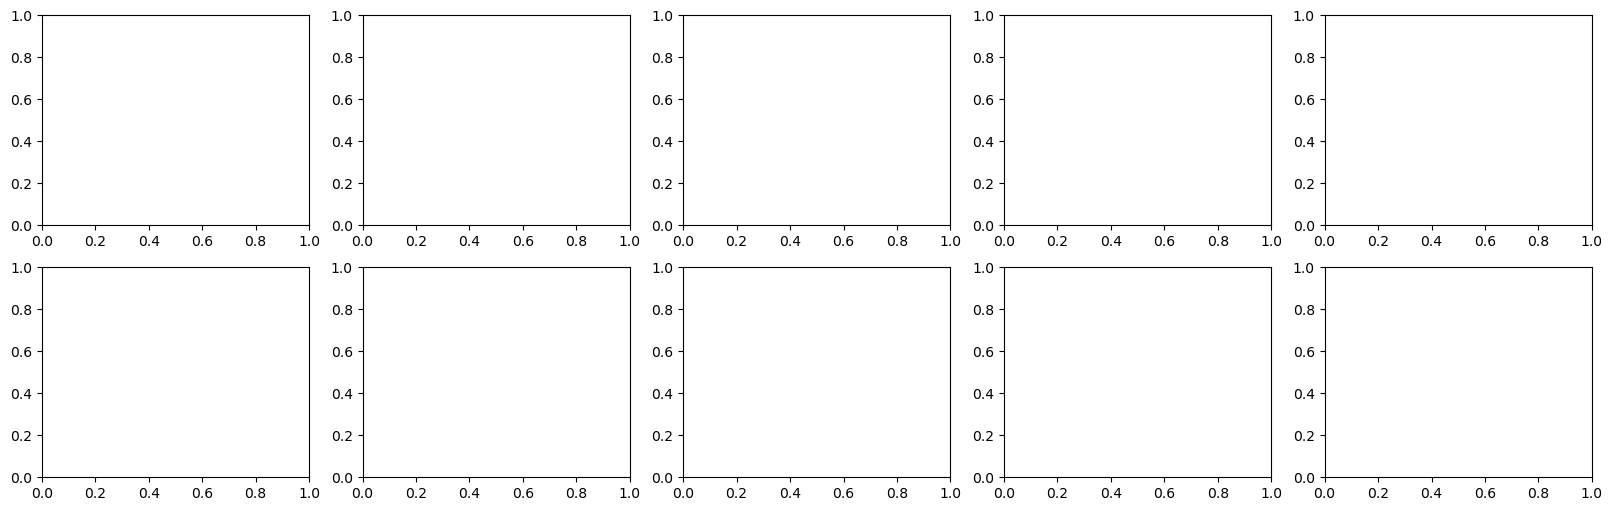

In [66]:
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]
ncols   = 5
nrows   = int(math.ceil(len(k_values) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)
axes_flat = axes.flatten()

corr = []

for idx, k in enumerate(k_values):
    density = density_list[idx]

    max_density_index = len(density)  # upper bound (exclusive)

    # Filter reconstruction entries to those that have a density available
    filtered_reconst_losses = [
        rec for rec in reconst_losses
        if 'image_id' in rec and isinstance(rec['image_id'], (int, str))
        and int(rec['image_id']) < max_density_index
    ]

    # it should be a list of densities for each data point
    processed_density = [sum(l[0][:]) + l[0][1] for l in density] 
    ds = ReconstructionDataset_Heuristic(
        reconstruction_data=filtered_reconst_losses,  # or your processed list of dicts
        local_density_information=processed_density, # [l[0] for l in density]
        error_key=["LPIPS"],
    )
    ax = axes_flat[idx]
    densities    = []
    losses_lpips = []
    for data_point in ds:
        if data_point['k_value'] == k:
            densities.append(data_point['local_density'])
            losses_lpips.append(data_point['LPIPS'])

    # First hexbin: LPIPS vs density
    hb1 = ax.hexbin(densities, losses_lpips, gridsize=50, cmap='Blues', mincnt=1)
    if len(densities) > 1:
        corr1 = np.corrcoef(densities, losses_lpips)[0, 1]
    else:
        corr1 = float('nan')
    ax.set_title(f"k={k} LPIPS (r={corr1:.2f})")
    ax.set_xlabel('Local Density')
    ax.set_ylabel('Reconstruction Loss (LPIPS)')

    corr.append(corr1)

    # Optionally add a colorbar for the first hexbin
    fig.colorbar(hb1, ax=ax, orientation='vertical', pad=0.01, fraction=0.05)

# Hide unused subplots (if grid larger than number of k_values)
for j in range(len(k_values), nrows * ncols):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

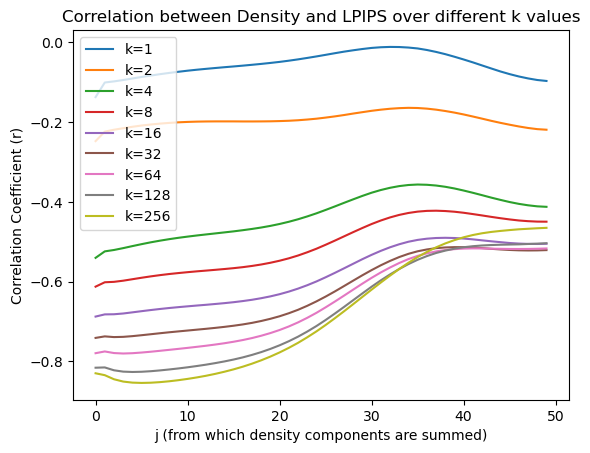

In [ ]:
# for each k, plot correlation over j
for idx, k in enumerate(k_values):
    corr_k = [corrs[j][idx] for j in range(50)]
    plt.plot(range(50), corr_k, label=f'k={k}')
    # label=f'k={k}'
plt.legend()
plt.title("Correlation between Density and LPIPS over different k values")
plt.xlabel("j (from which density components are summed)")
plt.ylabel("Correlation Coefficient (r)")
plt.show()

['-0.10', '-0.22', '-0.41', '-0.45', '-0.50', '-0.52', '-0.52', '-0.50', '-0.47']


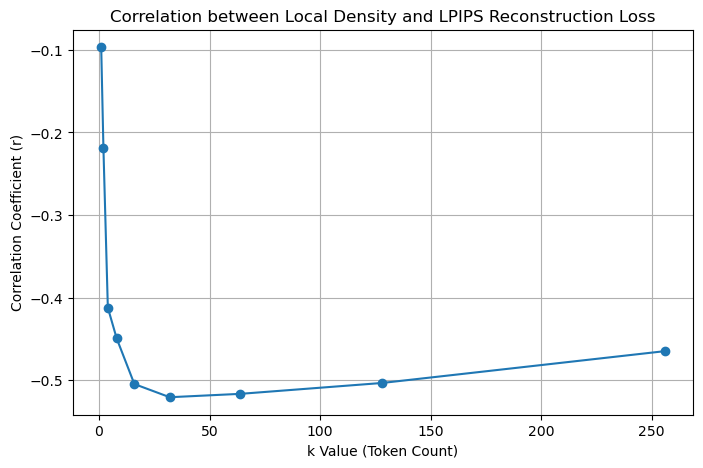

In [ ]:
print([f"{i:.2f}" for i in corr])
# plot correlation vs k_values
plt.figure(figsize=(8, 5))
plt.plot(k_values, corr, marker='o')
#plt.xscale('log', base=2)
plt.xlabel('k Value (Token Count)')
plt.ylabel('Correlation Coefficient (r)')
plt.title('Correlation between Local Density and LPIPS Reconstruction Loss')
plt.grid(True)
plt.show()